In [1]:
import os
import errno

import sys
print(sys.executable)
print(sys.version)

import traceback
import json

import numpy as np

import deepcell
import matplotlib.pyplot as plt

from deepcell.datasets.tracked import hek293,nih_3t3_bench,nih_3t3,hek293_bench,hela_s3_bench,raw2647_bench
from deepcell.datasets.cytoplasm import hela,nih_3t3,cho
from PIL import Image
import imageio
import cv2
import random

import imgaug.augmenters as iaa

import torch
import torchvision.transforms.functional as TF

from skimage import io
import tifffile as tiff

from sklearn.cluster import KMeans

from skimage.transform import resize
import pandas as pd
from deepcell_tracking.trk_io import load_trks
from scipy.optimize import curve_fit

/home/mo/anaconda3/envs/cell/bin/python
3.9.16 (main, Mar  8 2023, 14:00:05) 
[GCC 11.2.0]


2023-08-24 21:47:06.276195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mo/anaconda3/envs/cell/lib/python3.9/site-packages/cv2/../../../../lib:
2023-08-24 21:47:06.276261: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/mo/anaconda3/envs/cell/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mo/anaconda3/envs/cell/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def crop_image(img, start_x=0, end_x=512, start_y=0, end_y=512):
    return img[start_y:end_y, start_x:end_x]

#def crop_image(img, start_x=0, end_x=512, start_y=0, end_y=512):
#    return img

def mean_per_index(lists):
    result = []
    
    # iterate through each index
    for idx in range(len(lists[0])):
        total, count = 0, 0
        
        # iterate through each list
        for sublist in lists:
            if sublist[idx] != 0: # check if the value is non-zero
                total += sublist[idx]
                count += 1
        
        # append the mean value to the result list
        result.append(total / count if count > 0 else 0)
    
    return result


def std_per_index(lists):
    means = mean_per_index(lists)
    std_results = []
    
    # iterate through each index
    for idx in range(len(lists[0])):
        sum_sq_diffs, count = 0, 0
        
        # iterate through each list
        for sublist in lists:
            if sublist[idx] != 0:  # check if the value is non-zero
                sum_sq_diffs += (sublist[idx] - means[idx])**2
                count += 1
        
        # append the standard deviation to the std_results list
        std_results.append((sum_sq_diffs / count)**0.5 if count > 0 else 0)
    
    return std_results


In [3]:
data_dir = '/media/mo/Label/DynamicNuclearNet-tracking-v1_0/'
data = load_trks(os.path.join(data_dir, 'test.trks'))

X = data['X']
y = data['y']
lineages = data['lineages']

data_source = np.load(os.path.join(data_dir, 'data-source.npz'), allow_pickle=True)
meta = pd.DataFrame(data_source['test'], columns=['filename', 'experiment', 'pixel_size', 'screening_passed', 'time_step', 'specimen'])

In [4]:
print(X.shape)
print(lineages[0])

(12, 71, 584, 600, 1)
{1: {'label': 1, 'frames': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41], 'daughters': [], 'capped': False, 'frame_div': None, 'parent': None}, 2: {'label': 2, 'frames': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41], 'daughters': [], 'capped': False, 'frame_div': None, 'parent': None}, 3: {'label': 3, 'frames': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41], 'daughters': [], 'capped': False, 'frame_div': None, 'parent': None}, 4: {'label': 4, 'frames': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41], 'daughters': [], 'cappe

Gaussian 1: A = 2250.390122, mu = 303.290562, sigma = 65.647754, Area = 308593.213780
Gaussian 2: A = 648.382786, mu = 733.493603, sigma = 227.531657, Area = 308164.064262
Gaussian displacement: A = 1308.289747, mu = 0.523576, sigma = 0.510391
Gaussian split_prob: A = 0.130718, mu = 3.924847, sigma = -1.703821
Shape of mean_relative_sizes: [1.         0.99384902 0.98191173 0.94747785 0.89622531 0.8441114
 0.73482019 0.73691158 0.42509193 0.48386286 0.5469356  0.58980505
 0.61703697 0.64324492 0.65676972] [0.         0.08489595 0.11923828 0.15931407 0.20833737 0.27617642
 0.26774939 0.26367618 0.13294053 0.14793629 0.16084162 0.16405491
 0.1584962  0.15382308 0.15610992]
fit_area_over_time [0.55618812 1.54775129 0.01123954] vkl [ 0.29749446  1.30716996 -0.28077059]


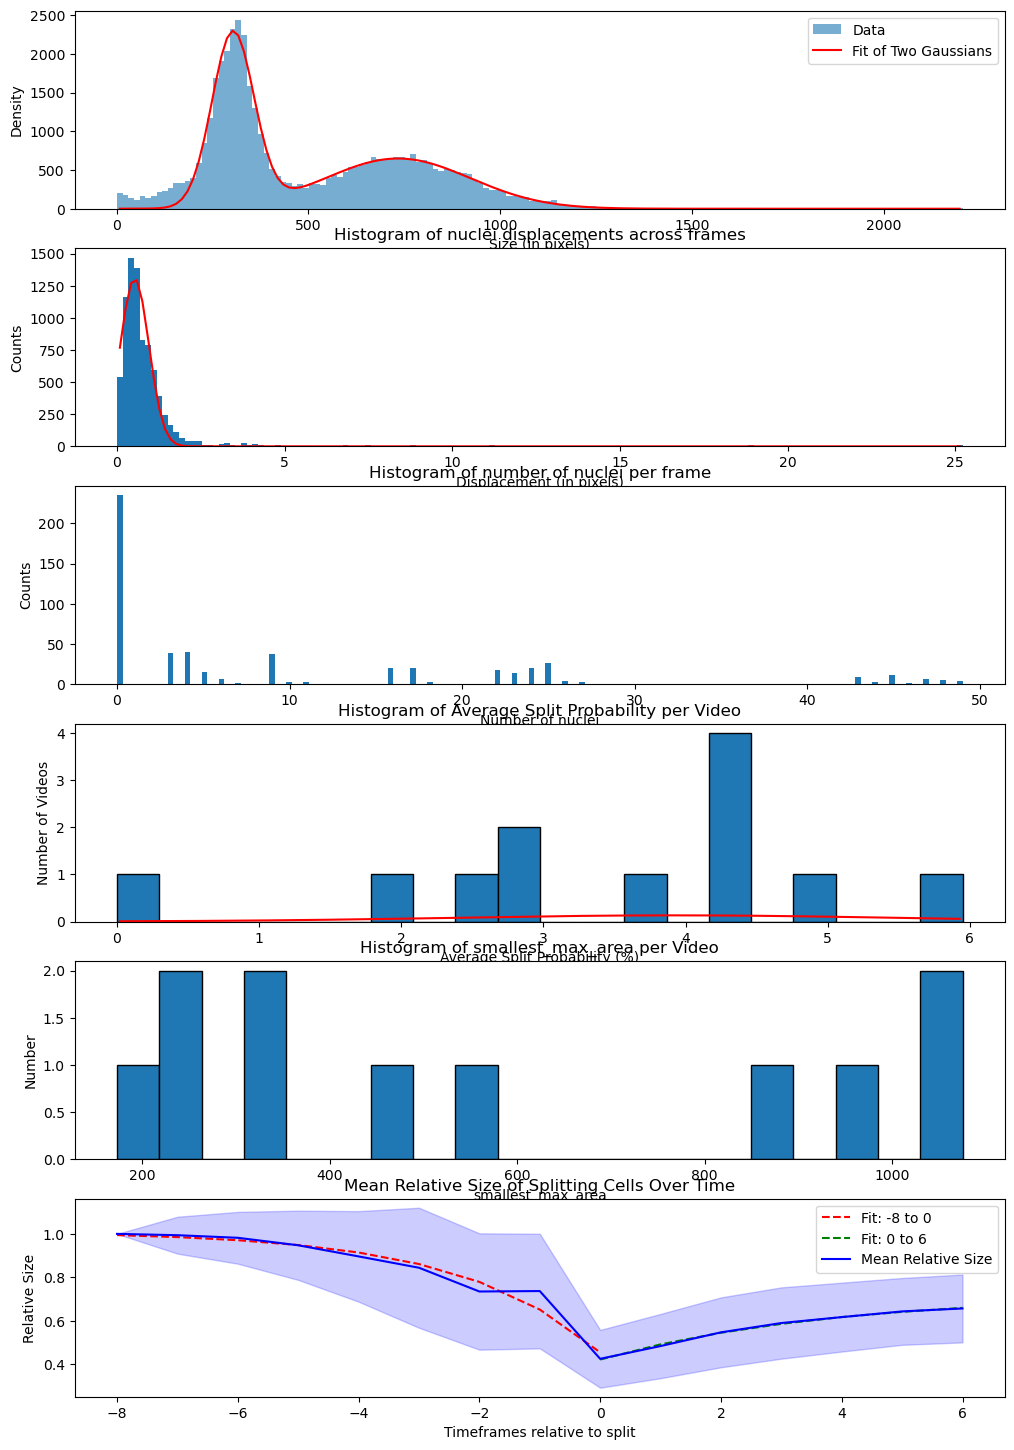

<Figure size 640x480 with 0 Axes>

In [7]:
fig, axes = plt.subplots(6, 1, figsize=(12, 18))

# Histogram 1: Size distribution
all_counts = []

for vid in range(12):  # iterating over videos
    for frame_num in range(71):  # iterating over frames within a video
        frame = crop_image(y[vid, frame_num, :, :, 0])
        unique_values, counts = np.unique(frame, return_counts=True)
        #print('counts', unique_values,counts)
        non_zero_indices = unique_values != 0
        counts = counts[non_zero_indices]#/(584*600)
        #counts= np.sqrt(counts/np.pi)
        all_counts.extend(counts)

# Define the sum of two Gaussians
def two_gaussians(x, A1, mu1, sigma1, A2, mu2, sigma2):
    g1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
    g2 = A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2))
    return g1 + g2
def one_gaussian(x, A1, mu1, sigma1):
    g1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
    return g1


def func_neg(x, a, b, c):
    return (1 - a * (b ** x)) + c

def func_pos(x, a, b, c):
    return (1 - a * (b ** (-x))) + c

# Create histogram
counts, bin_edges = np.histogram(all_counts, bins=150, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit the function to the histogram data
params, covariance = curve_fit(two_gaussians, bin_centers, counts, p0=(1200, 400, 50, 400, 750, 150))

A1, mu1, sigma1, A2, mu2, sigma2 = params

# Plot histogram and fitted function
axes[0].hist(all_counts, bins=150, density=False, alpha=0.6, label="Data")
axes[0].plot(bin_centers, two_gaussians(bin_centers, *params), 'r-', label="Fit of Two Gaussians")
axes[0].set_xlabel("Size (in pixels)")
axes[0].set_ylabel("Density")
axes[0].legend()


area_g1 = A1 * np.sqrt(2 * np.pi) * sigma1
area_g2 = A2 * np.sqrt(2 * np.pi) * sigma2

# Print the parameters
print(f"Gaussian 1: A = {A1:.6f}, mu = {(mu1):.6f}, sigma = {(sigma1*1.2):.6f}, Area = {area_g1:.6f}")
print(f"Gaussian 2: A = {A2:.6f}, mu = {(mu2):.6f}, sigma = {(sigma2*1.2):.6f}, Area = {area_g2:.6f}")


# Histogram 2: Movement/Displacement distribution
displacements = []

for video_lineage in lineages:
    for nucleus, data in video_lineage.items():
        frames = data['frames']
        for i in range(1, len(frames)):
            previous_frame = crop_image(y[frames[i-1] // 71, frames[i-1] % 71, :, :, 0])  # cropping the frame
            current_frame = crop_image(y[frames[i] // 71, frames[i] % 71, :, :, 0])  # cropping the frame
            
            previous_centroid = np.argwhere(previous_frame == nucleus)
            current_centroid = np.argwhere(current_frame == nucleus)
            
            if previous_centroid.size == 0 or current_centroid.size == 0:
                continue  # skip to next iteration if no nucleus is found
            
            previous_centroid = previous_centroid.mean(axis=0)
            current_centroid = current_centroid.mean(axis=0)
            
            displacement = np.linalg.norm(current_centroid - previous_centroid)
            displacements.append(displacement)

displacements = np.array(displacements)
if np.any(np.isnan(displacements)):
    print("Warning: NaN values found in displacements!")
    displacements = displacements[~np.isnan(displacements)] 
            
displacements_count, bin_edges = np.histogram(displacements, bins=150, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

params, covariance = curve_fit(one_gaussian, bin_centers, displacements_count, p0=(1200, 2, 10))

A1, mu1, sigma1 = params
print(f"Gaussian displacement: A = {A1:.6f}, mu = {(mu1):.6f}, sigma = {((sigma1*1.2)):.6f}")


axes[1].hist(displacements, bins=150)
axes[1].plot(bin_centers, one_gaussian(bin_centers, *params), 'r-', label="Fit of One Gaussians")
axes[1].set_title('Histogram of nuclei displacements across frames')
axes[1].set_xlabel('Displacement (in pixels)')
axes[1].set_ylabel('Counts')

# Histogram 3: Number of instances per frame
num_instances = []

for vid in range(12):
    for frame_num in range(71):
        frame = crop_image(y[vid, frame_num, :, :, 0])
        num_instances.append(len(np.unique(frame))-1)
        
        
filtered_instances = [n for n in num_instances if n < 50]

axes[2].hist(filtered_instances, bins=150)
axes[2].set_title('Histogram of number of nuclei per frame')
axes[2].set_xlabel('Number of nuclei')
axes[2].set_ylabel('Counts')





split_probabilities = []

# For each video
# For each video
for vid in lineages:

    splits = 0
    total_frames_before_split = 0

    # For each cell in the video
    for cell_id, cell_data in vid.items():
        if cell_data['daughters']:  # If the cell has daughters, it splits
            splits += 1
            total_frames_before_split += len(cell_data['frames'])  # Number of frames before split

    # Compute the split probability for this video
    if total_frames_before_split != 0:
        split_probability = (splits / total_frames_before_split) * 100  # in percent
    else:
        split_probability = 0
    
    split_probabilities.append(split_probability)

    
split_probabilities = np.array(split_probabilities)
 
            
split_probabilities_count, bin_edges = np.histogram(split_probabilities, bins=150, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

params, covariance = curve_fit(one_gaussian, bin_centers, split_probabilities_count, p0=(3, 2, 10))

A1, mu1, sigma1 = params
print(f"Gaussian split_prob: A = {A1:.6f}, mu = {(mu1):.6f}, sigma = {((sigma1*1.1)):.6f}")

# Plot histogram
axes[3].hist(split_probabilities, bins=20, edgecolor='k')
axes[3].plot(bin_centers, one_gaussian(bin_centers, *params), 'r-', label="Fit of One Gaussians")
axes[3].set_xlabel('Average Split Probability (%)')
axes[3].set_ylabel('Number of Videos')
axes[3].set_title('Histogram of Average Split Probability per Video')



smallest_max_areas = []

# For each video
for vid, segmentation in zip(lineages, y):

    smallest_max_area_for_video = np.inf

    # For each cell in the video
    for cell_id, cell_data in vid.items():
        if cell_data['daughters']:  # If the cell has daughters, it splits
            max_area_for_cell = 0

            # For each frame the cell exists in
            for frame_num in cell_data['frames']:
                # Compute the area of the cell in this frame
                area = np.sum(segmentation[frame_num] == cell_id)
                max_area_for_cell = max(max_area_for_cell, area)

            # Check if this cell has the smallest max area seen so far in this video
            smallest_max_area_for_video = min(smallest_max_area_for_video, max_area_for_cell)

    # If we found any splitting cells in the video, store the smallest max area
    if smallest_max_area_for_video != np.inf:
        smallest_max_areas.append(smallest_max_area_for_video)


axes[4].hist(smallest_max_areas, bins=20, edgecolor='k')
axes[4].set_xlabel('smallest_max_area')
axes[4].set_ylabel('Number')
axes[4].set_title('Histogram of smallest_max_area per Video')

#cell area over time

# Find splitting cells and gather their size data for the specified timeframes.
split_data = []

for video_idx, vid in enumerate(lineages):

    # For each cell in the video.
    for cell_id, cell_data in vid.items():
        if cell_data['daughters'] and len(cell_data['frames']) >= 8:  # Cell splits and existed for at least 8 frames before split.

            # Handle inconsistency in frame_div
            frames_before_split = cell_data['frames']
            if cell_data['frame_div'] not in frames_before_split:
                frames_before_split.append(cell_data['frame_div'])
                frames_before_split.sort()  # Ensure frames are in order
            
            # Extract 8 frames before the split
            start_idx = frames_before_split.index(cell_data['frame_div']) - 8
            end_idx = frames_before_split.index(cell_data['frame_div']) + 1  # +1 to include the split frame

            sizes = []

            # Get sizes from original cell before the split
            for idx in range(start_idx, end_idx):
                #print('seg',y[video_idx, frames_before_split[idx], :, :] == cell_id)
                size = np.sum(y[video_idx, frames_before_split[idx], :, :] == cell_id)
                sizes.append(size)

            # Get sizes from daughter cells after the split
            for post_split_frame in range(1, 7):  # 6 frames after the split
                frame_num = cell_data['frame_div'] + post_split_frame
                
                total_daughter_size = 0
                try:
                    for daughter in cell_data['daughters']:
                        total_daughter_size += np.sum(y[video_idx, frame_num, :, :] == daughter)
                
                    # Compute the mean size of daughter cells
                    mean_daughter_size = total_daughter_size / len(cell_data['daughters'])
                    sizes.append(mean_daughter_size)
                except:
                    sizes.append(0)

            #print('sizes', sizes)

            if len(sizes) == 15:  # 8 frames before the split + the split frame + 6 frames after the split
                split_data.append(sizes)

relative_sizes = []
for sizes in split_data:
    base_size = sizes[0]
    relative = [size / base_size for size in sizes]
    relative_sizes.append(relative)

mean_relative_sizes = np.array(mean_per_index(relative_sizes))
std_dev_relative_sizes = np.array(std_per_index(relative_sizes))

#print("Length of relative_sizes:", len(relative_sizes))
print("Shape of mean_relative_sizes:", mean_relative_sizes,std_dev_relative_sizes)

for i, rel_size in enumerate(relative_sizes):
    if len(rel_size) != 15:
        print(f"Entry {i} in relative_sizes has length {len(rel_size)}!")
        
        
x_data_neg = np.array(range(-8, 1))
y_data_neg = mean_relative_sizes[:9]

x_data_pos = np.array(range(0, 7))
y_data_pos = mean_relative_sizes[8:]


popt_neg, _ = curve_fit(func_neg, x_data_neg, y_data_neg)
popt_pos, _ = curve_fit(func_pos, x_data_pos, y_data_pos)

print('fit_area_over_time',popt_neg,'vkl' ,popt_pos)

axes[5].plot(x_data_neg, func_neg(x_data_neg, *popt_neg), 'r--', label='Fit: -8 to 0')
axes[5].plot(x_data_pos, func_pos(x_data_pos, *popt_pos), 'g--', label='Fit: 0 to 6')

axes[5].plot(range(-8, 7), mean_relative_sizes, label='Mean Relative Size', color='blue')
axes[5].fill_between(range(-8, 7), 
                     mean_relative_sizes - std_dev_relative_sizes, 
                     mean_relative_sizes + std_dev_relative_sizes, 
                     color='blue', alpha=0.2)
axes[5].set_xlabel('Timeframes relative to split')
axes[5].set_ylabel('Relative Size')
axes[5].set_title('Mean Relative Size of Splitting Cells Over Time')
axes[5].legend()

plt.show()

plt.tight_layout()
plt.show()

[0 1 2 3 4 5]


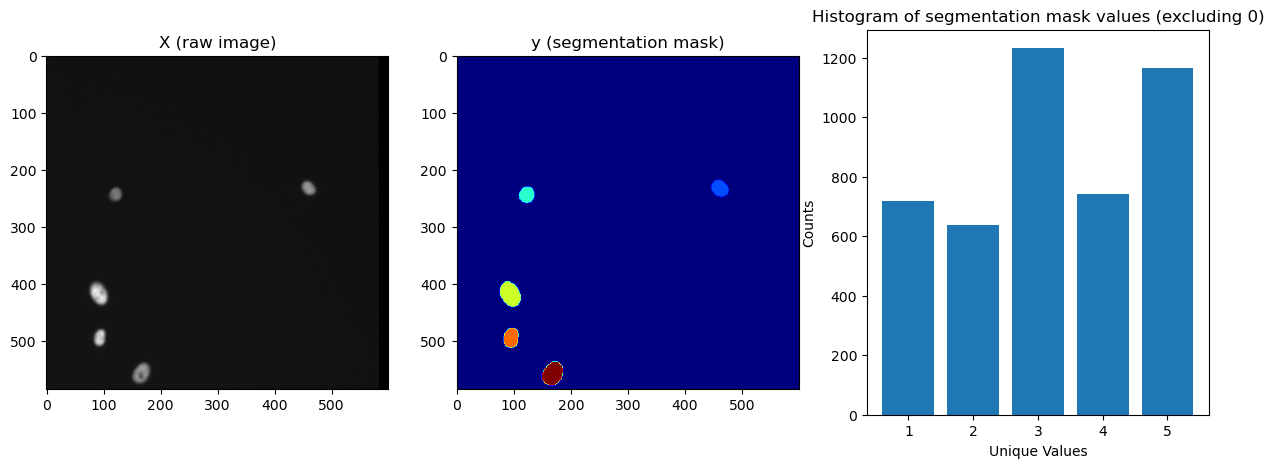

In [6]:
track_id = 6
frame_id = 1

# Load the data
X_frame = X[track_id, frame_id, ..., 0]  # This is assuming channels are last, adjust if necessary
y_frame = y[track_id, frame_id, ..., 0]  # This is assuming channels are last, adjust if necessary
#lineage = lineages[track_id, frame_id, ..., 0]
# Create a figure with two subplots
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the image and label
axes[0].imshow(X_frame, cmap='gray')  # gray scale for raw image
axes[0].set_title('X (raw image)')

axes[1].imshow(y_frame, cmap='jet')  # jet colormap for segmentation mask
axes[1].set_title('y (segmentation mask)')

# Remove the x and y ticks
#for ax in axes:
#    ax.set_xticks([])
#    ax.set_yticks([])

# Find the unique values in the segmentation mask and their counts
unique_values, counts = np.unique(y_frame, return_counts=True)
print(unique_values)
# Exclude zeros
non_zero_indices = unique_values != 0
unique_values = unique_values[non_zero_indices]
counts = counts[non_zero_indices]

# Plot a histogram of the unique values
axes[2].bar(unique_values, counts)
axes[2].set_title('Histogram of segmentation mask values (excluding 0)')
axes[2].set_xlabel('Unique Values')
axes[2].set_ylabel('Counts')

plt.show()
